In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
import pickle
import pandas as pd
import SyntheticData as sd
import Sampler
import json

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [ ]:
mdwarfs = Table.read('./data/200pc_mdwarfs_reduced.fits', format='fits')
all_mdwarfs = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in tqdm(mdwarfs): # we don't need every object, really 
    df = dict()
    for item in relevant_list:
        working_item = item
        if item == "mass":
            working_item = "mass_single"
        df[item] = float(row[working_item])
    all_mdwarfs.append(df)
    
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])-5
masses = np.array([t["mass"] for t in all_mdwarfs])
mass_lims = np.percentile(masses, percentiles) 

  0%|          | 0/260095 [00:00<?, ?it/s]

In [3]:
data_52 = sd.create_synthetic_data(object_count=50000, catalogue=mdwarfs[::2], binary_fraction=0.3, period_model=(5,2), mass_model=None, ecc_type='circular')
data_413 = sd.create_synthetic_data(object_count=50000, catalogue=mdwarfs[::2], binary_fraction=0.3, period_model=(4,1.3), mass_model=None, ecc_type='circular')
data_42 = sd.create_synthetic_data(object_count=50000, catalogue=mdwarfs[::2], binary_fraction=0.3, period_model=(4,2), mass_model=None, ecc_type='circular')

Computing Binaries:   0%|          | 0/15000 [00:00<?, ?it/s]

Computing Binaries:   0%|          | 0/15000 [00:00<?, ?it/s]

Computing Binaries:   0%|          | 0/15000 [00:00<?, ?it/s]

In [4]:
outdata = dict()
outdata["meta"] = dict()
outdata["meta"]["metaparams"] = f"{0.3} Binary fraction, {0} q index, P(T): (4,1.3),(4,2),(5,2)"
outdata["meta"]["notes"] = "2026.01.11 250k samples, circular only, flat in q, three different period models"
outdata["data"] = dict()
outdata["data"]["(4,1.3)"] = data_413
outdata["data"]["(4,2)"] = data_42
outdata["data"]["(5,2)"] = data_52

outfile = open('./massive_data/period_samples.pkl', "wb")
pickle.dump(outdata, outfile)
outfile.close()

In [7]:
data_413 = pickle.load(open("./massive_data/period_samples.pkl", "rb"))["data"]["(4,1.3)"]
data_42 = pickle.load(open("./massive_data/period_samples.pkl", "rb"))["data"]["(4,2)"]
data_52 = pickle.load(open("./massive_data/period_samples.pkl", "rb"))["data"]["(5,2)"]
synthdatasets = [data_413, data_42, data_52]

In [4]:
sc_cubes_singular = pickle.load(open("./data/2025-12-10-200pc_mdwarf_circular_3plx.pkl", "rb"))

  0%|          | 0/9 [00:00<?, ?it/s]

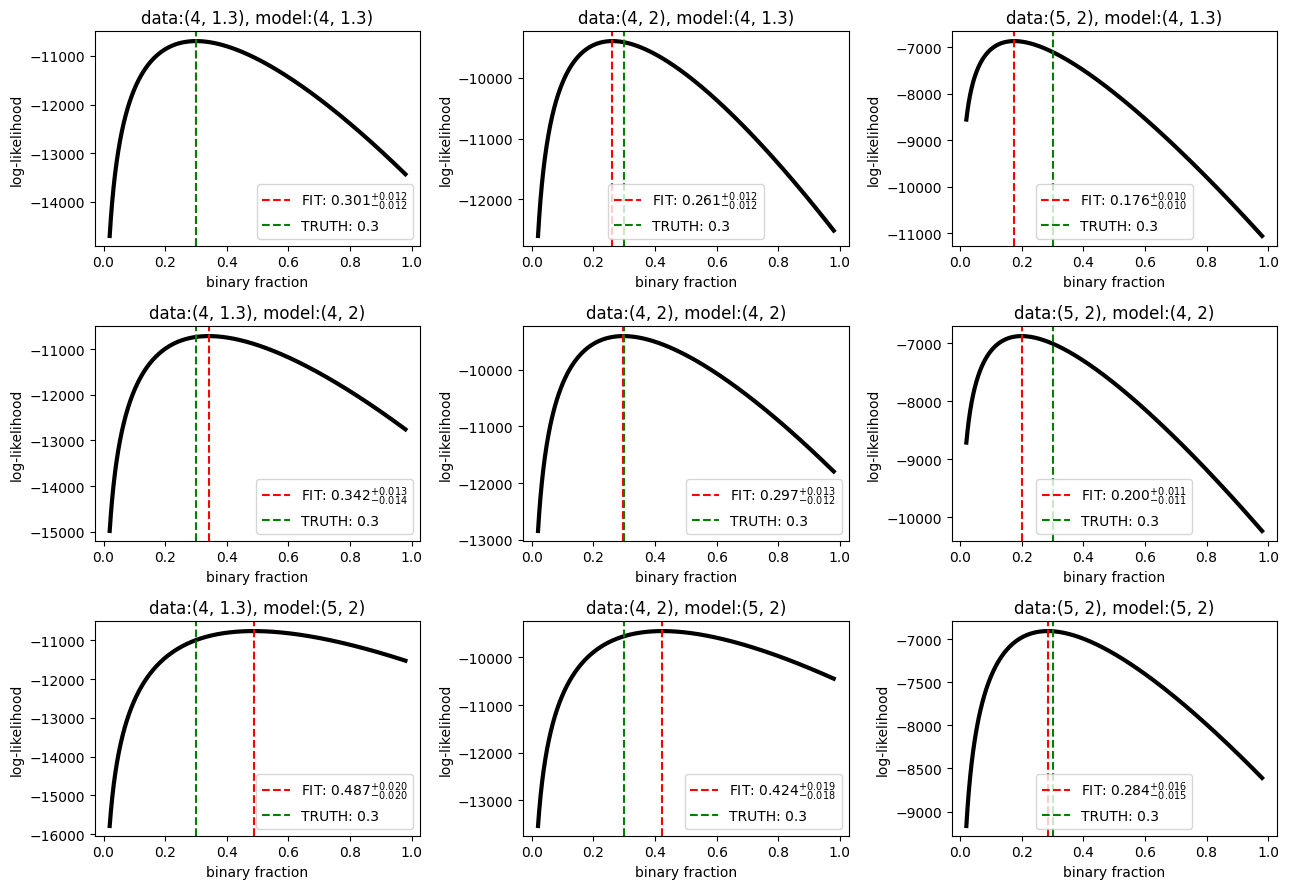

In [9]:
p_models = [(4,1.3), (4,2), (5,2)]
binary_fraction = 0.3
res = np.zeros((len(p_models), len(p_models), 2, 1000))
res_est = np.zeros((len(p_models), len(p_models), 3))

fig, axs = plt.subplots(3,3, figsize=(13,9))

pbar = tqdm(total=len(p_models)*len(synthdatasets))
for i, p_model in enumerate(p_models):
    for j in range(len(synthdatasets)):
        ax = axs[i,j]
        synthdata = synthdatasets[j]
        working_catalogue = []
        relevant_list = ["parallax", "mass", "solution_type"]
        for row in synthdata:
            df = dict()
            for item in relevant_list:
                df[item] = float(row[item])
            working_catalogue.append(df)
        model_cube = Sampler.create_model_cube((25,15), p_model)
        synthsampler = Sampler.popsampler(sc_cubes_singular, working_catalogue, model_cube=model_cube)
        res[i,j] = synthsampler.binarity(resolution=1000, scale=2, verbose=False)
        mle, p, m = synthsampler.fb_estimator()
        res_est[i,j] = [mle, p, m]
        ax.plot(synthsampler.fbs, synthsampler.likelihoods, c="black", linewidth=3);
        ax.axvline(x=mle, c="red", linestyle="--", label=r'FIT: ${:.3f}^{{+{:.3f}}}_{{-{:.3f}}}$'.format(mle,p,m));
        ax.axvline(x=binary_fraction, c="green", linestyle="--", label=f"TRUTH: {binary_fraction}")
        ax.set_xlabel("binary fraction");
        ax.set_ylabel("log-likelihood");
        ax.set_title(f"data:{p_models[j]}, model:{p_models[i]}")
        ax.legend();
        pbar.update(1)
plt.tight_layout()

In [26]:
outdata = dict()
outdata["meta"] = dict()
outdata["notes"] = "2026.01.12 periods with 413, 42, 52 tested on each other"
outdata["data"] = dict()
outdata["data"] = [res, res_est]

outfile = open('./plot_data/period_test.pkl', "wb")
pickle.dump(outdata, outfile)
outfile.close()

### Make plot

In [2]:
import style

In [9]:
res, res_est = pickle.load(open("./plot_data/period_test.pkl", "rb"))["data"]

In [5]:
binary_fraction = 0.3

/tmp/ipykernel_1225715/2752031293.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend();
/tmp/ipykernel_1225715/2752031293.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title=legend_label[:-1])


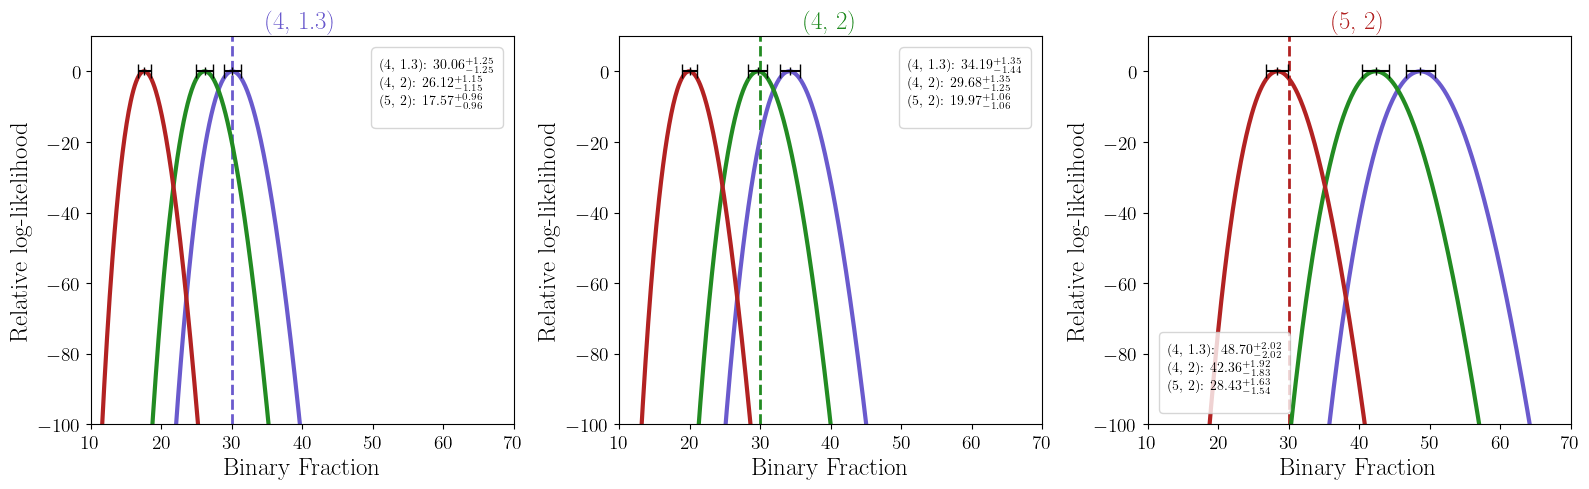

In [13]:
fig, axs = plt.subplots(1,3, figsize=(16,5))
cols = ['slateblue', 'forestgreen', 'firebrick']
p_models = [(4,1.3), (4,2), (5,2)]
for i, p_model in enumerate(p_models):
    ax = axs[i]
    ax.axvline(x=binary_fraction*100, c=cols[i], linestyle="--", linewidth=2);#, label=f"TRUTH: {binary_fraction}")
    ax.legend();
    legend_label = ''
    for j in range(len(synthdatasets)):
        fbs, likelihoods = res[i,j]
        mle, p, m  = res_est[i, j]
        ax.plot(fbs*100, likelihoods-np.max(likelihoods), c=cols[j], linewidth=3);
        legend_label = legend_label + r'{}: ${:.2f}^{{+{:.2f}}}_{{-{:.2f}}}$'.format(p_models[j],mle*100,p*100,m*100) + "\n"
        ax.errorbar(mle*100, 0, xerr=([p*100], [m*100]), c="k", marker='|', capsize=5, zorder=2)
        ax.set_xlabel("Binary Fraction");
        ax.set_ylabel("Relative log-likelihood");
        ax.set_title(f"{p_models[i]}", color=cols[i])
    ax.legend(title=legend_label[:-1])
    ax.set_ylim(top=10, bottom=-100)
    ax.set_xlim([10,70])
plt.tight_layout()
#plt.savefig("./plots/2026-01-12-period_test.png", dpi=800)

In [18]:
latex_table_grid = "\\begin{tabular}{lccc}\n\\toprule\nData $\\backslash$ Model & (4, 1.3) & (4, 2) & (5, 2) \\\\\n\\midrule\n"
for i, pdata in enumerate(p_models):
    row = f"{pdata} "
    for j, mdata in enumerate(p_models):
        mle_val = res_est[i, j, 0] * 100
        p_val = res_est[i, j, 1] * 100
        m_val = res_est[i, j, 2] * 100
        row += f"& ${mle_val:.2f}^{{+{p_val:.2f}}}_{{-{m_val:.2f}}}$ "
    row += "\\\\\n"
    latex_table_grid += row
latex_table_grid += "\\bottomrule\n\\end{tabular}"
print(latex_table_grid)

\begin{tabular}{lccc}
\toprule
Data $\backslash$ Model & (4, 1.3) & (4, 2) & (5, 2) \\
\midrule
(4, 1.3) & $30.06^{+1.25}_{-1.25}$ & $26.12^{+1.15}_{-1.15}$ & $17.57^{+0.96}_{-0.96}$ \\
(4, 2) & $34.19^{+1.35}_{-1.44}$ & $29.68^{+1.35}_{-1.25}$ & $19.97^{+1.06}_{-1.06}$ \\
(5, 2) & $48.70^{+2.02}_{-2.02}$ & $42.36^{+1.92}_{-1.83}$ & $28.43^{+1.63}_{-1.54}$ \\
\bottomrule
\end{tabular}
